# IF867 - Introdução à Aprendizagem Profunda
## 1ª atividade prática - 2025.1

Discente(s):
- Ana Sofia Lima (asosl)
- João Vitor Mergulhão (jvlm2)

## Instruções e requisitos
- Objetivo: Implementar e treinar um Multi-Layer Perceptron e uma Rede Neural Convolucional, inteiramente em PyTorch.
- Observação: A atividade pode ser feita em dupla.

## Tarefa

- Rede Neural Convolucional (CNN) (50% da nota):
  - Implementação: Proponha e construa sua própria arquitetura de CNN.
  - Implemente funções para o treinamento e avaliação do modelo.
  - Métricas e Análise:
    - Registre o tempo de treinamento de cada configuração.
    - Gere e apresente a matriz de confusão para os resultados da classificação.
    - Plote gráficos da função de loss e da acurácia ao longo das épocas de treinamento.
  - Experimentação:
    - Aplique e avalie técnicas de regularização (ex: Dropout, Batch Normalization).
    - Implemente e analise o Grad-CAM para visualização e interpretabilidade.
    - Explore outras técnicas relevantes para otimização ou análise de CNNs.
  - Relatório: Documente no notebook os experimentos realizados, as configurações utilizadas e os resultados obtidos, analisando o impacto de cada alteração.

O dataset escolhido foi o CIFAR10:
- Imagens 32x32
- composto por 10 classes

## Imports

In [ ]:
import torch
from  torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset setup

In [ ]:
# Define as transformações com data augmentation para o treinamento
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define as transformações sem data augmentation
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_val_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_val_dataset_plain = CIFAR10(root='./data', train=True, download=True, transform=val_test_transform)

# Extrai os rótulos
targets = np.array(train_val_dataset_plain.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)     # com augmentation
    val_dataset = Subset(train_val_dataset_plain, val_idx)       # sem augmentation

# Dataset de teste também sem augmentation
test_dataset = CIFAR10(root='./data', train=False, download=False, transform=val_test_transform)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32,
                                          shuffle = True, num_workers=2)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32,
                                          shuffle = False, num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32,
                                          shuffle = False, num_workers=2)

## Data visualization

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

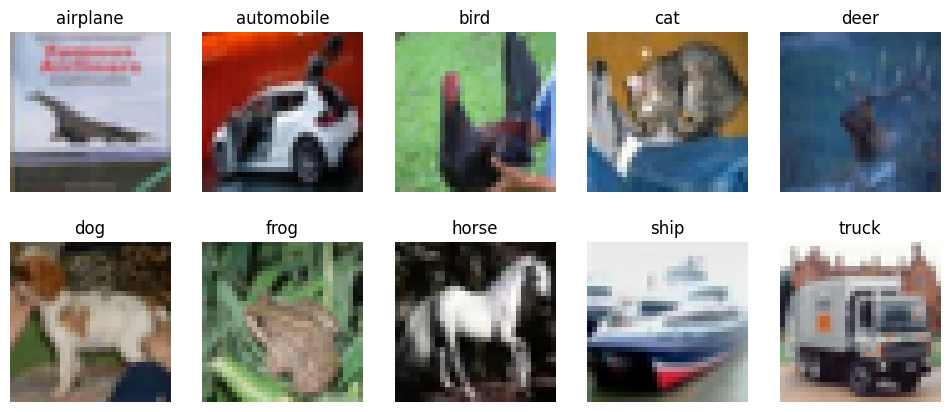

In [ ]:
classes = test_dataset.classes

# Encontrar uma imagem de cada classe
images_per_class = {}
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = img
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(images_per_class) == len(classes):
        break

# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i, class_name in enumerate(classes):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    ax.set_title(class_name)
    imshow(images_per_class[class_name])

plt.show()

## Evaluation Functions

In [ ]:
def evaluate(net, loader, loss_function):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    net.train()
    return val_loss / len(loader)

In [ ]:
def plotLoss(train_losses, val_losses):
    plt.plot(train_losses, label='Treinamento')
    plt.plot(val_losses, label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [ ]:
def makePredictions(net, test_loader):
  net.eval()
  predictions = []
  labels = []
  for images, label in test_loader:
    images = images.to(device)
    label = label.to(device)

    output = net(images)
    _, predicted = torch.max(output,1)

    predictions.extend(predicted.cpu().numpy())
    labels.extend(label.cpu().numpy())

  return labels, predictions

## CNN Definition

In [ ]:
#Definir arquitetura da rede

# bloco convolucional -> convoluções seguidas de um max pool
def conv_block(num_convs, out_channels, batch_norm=False):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))

        # BatchNorm após convolução
        if batch_norm:
          layers.append(nn.LazyBatchNorm2d())

        layers.append(nn.ReLU())

    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

class CNN(nn.Module):
    def __init__(self, arch, num_classes=10, batch_norm=False, dropout=0.0):
        super().__init__()

        # camadas de convolução -> extração de features
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(conv_block(num_convs, out_channels, batch_norm))

        self.feature_extractor = nn.Sequential(*conv_blks)

        # Calcular a dimensão da saída do feature extractor automaticamente
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            dummy_output = self.feature_extractor(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]  # total de features

        # camadas completamente conectadas -> classificação
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


## Treinamento

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(net, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=3):
    net.to(device)

    train_losses = []
    val_losses = []

    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        net.train()
        epoch_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i + 1) % 1000 == 0:
              tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {loss:.4f}')

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validação
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        tqdm.write(f'Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch+1}")
                break

    # Restaura melhor modelo encontrado
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    return net, train_losses, val_losses

## Experimento 1

In [ ]:
# Hiperparâmetros
arch=((1, 64),
      (2, 128),
      (2, 256))

batch_size = 32
learning_rate = 1e-3
dropout = 0
batch_norm = False
num_epochs=40
patience=5

In [ ]:
#instancia a rede
net = CNN(arch=((1, 64), (2, 128), (2, 256)))
net.to(device)

#função de perda (loss)
criterion = nn.CrossEntropyLoss()

#otimizador
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
net, train_losses, val_losses = train_model(net, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, patience=patience)

# salvar o modelo treinado

torch.save(net.state_dict(), "best_model_exp1.pth")

  0%|          | 0/40 [00:15<?, ?it/s]

Epoch 1/40, Step 1000/1250, Loss: 1.5392


  2%|▎         | 1/40 [00:21<14:02, 21.59s/it]

Epoch 1 completed. Train Loss: 1.7462 | Val Loss: 1.4608


  2%|▎         | 1/40 [00:38<14:02, 21.59s/it]

Epoch 2/40, Step 1000/1250, Loss: 0.8847


  5%|▌         | 2/40 [00:44<14:07, 22.31s/it]

Epoch 2 completed. Train Loss: 1.3331 | Val Loss: 1.1760


  5%|▌         | 2/40 [01:00<14:07, 22.31s/it]

Epoch 3/40, Step 1000/1250, Loss: 1.1784


  8%|▊         | 3/40 [01:07<13:56, 22.61s/it]

Epoch 3 completed. Train Loss: 1.1274 | Val Loss: 1.0117


  8%|▊         | 3/40 [01:32<13:56, 22.61s/it]

Epoch 4/40, Step 1000/1250, Loss: 1.0810


 10%|█         | 4/40 [01:41<16:21, 27.26s/it]

Epoch 4 completed. Train Loss: 0.9902 | Val Loss: 0.8690


 10%|█         | 4/40 [02:00<16:21, 27.26s/it]

Epoch 5/40, Step 1000/1250, Loss: 0.8527


 12%|█▎        | 5/40 [02:12<16:43, 28.66s/it]

Epoch 5 completed. Train Loss: 0.8885 | Val Loss: 0.8199


 12%|█▎        | 5/40 [02:31<16:43, 28.66s/it]

Epoch 6/40, Step 1000/1250, Loss: 1.2728


 15%|█▌        | 6/40 [02:37<15:27, 27.28s/it]

Epoch 6 completed. Train Loss: 0.8192 | Val Loss: 0.8865


 15%|█▌        | 6/40 [02:52<15:27, 27.28s/it]

Epoch 7/40, Step 1000/1250, Loss: 0.8039


 18%|█▊        | 7/40 [02:59<14:06, 25.65s/it]

Epoch 7 completed. Train Loss: 0.7656 | Val Loss: 0.7278


 18%|█▊        | 7/40 [03:15<14:06, 25.65s/it]

Epoch 8/40, Step 1000/1250, Loss: 0.7587


 20%|██        | 8/40 [03:22<13:09, 24.69s/it]

Epoch 8 completed. Train Loss: 0.7181 | Val Loss: 0.7035


 20%|██        | 8/40 [03:37<13:09, 24.69s/it]

Epoch 9/40, Step 1000/1250, Loss: 0.7284


 22%|██▎       | 9/40 [03:43<12:09, 23.54s/it]

Epoch 9 completed. Train Loss: 0.6836 | Val Loss: 0.6536


 22%|██▎       | 9/40 [03:59<12:09, 23.54s/it]

Epoch 10/40, Step 1000/1250, Loss: 0.6279


 25%|██▌       | 10/40 [04:05<11:32, 23.07s/it]

Epoch 10 completed. Train Loss: 0.6541 | Val Loss: 0.7255


 25%|██▌       | 10/40 [04:20<11:32, 23.07s/it]

Epoch 11/40, Step 1000/1250, Loss: 0.9762


 28%|██▊       | 11/40 [04:27<11:01, 22.82s/it]

Epoch 11 completed. Train Loss: 0.6305 | Val Loss: 0.6616


 28%|██▊       | 11/40 [04:43<11:01, 22.82s/it]

Epoch 12/40, Step 1000/1250, Loss: 0.4324


 30%|███       | 12/40 [04:50<10:36, 22.72s/it]

Epoch 12 completed. Train Loss: 0.6077 | Val Loss: 0.6218


 30%|███       | 12/40 [05:05<10:36, 22.72s/it]

Epoch 13/40, Step 1000/1250, Loss: 1.0261


 32%|███▎      | 13/40 [05:11<09:59, 22.21s/it]

Epoch 13 completed. Train Loss: 0.5855 | Val Loss: 0.6613


 32%|███▎      | 13/40 [05:27<09:59, 22.21s/it]

Epoch 14/40, Step 1000/1250, Loss: 0.6377


 35%|███▌      | 14/40 [05:33<09:36, 22.19s/it]

Epoch 14 completed. Train Loss: 0.5684 | Val Loss: 0.6064


 35%|███▌      | 14/40 [05:48<09:36, 22.19s/it]

Epoch 15/40, Step 1000/1250, Loss: 0.2814


 38%|███▊      | 15/40 [05:55<09:13, 22.16s/it]

Epoch 15 completed. Train Loss: 0.5507 | Val Loss: 0.6176


 38%|███▊      | 15/40 [06:10<09:13, 22.16s/it]

Epoch 16/40, Step 1000/1250, Loss: 0.8164


 40%|████      | 16/40 [06:17<08:51, 22.14s/it]

Epoch 16 completed. Train Loss: 0.5376 | Val Loss: 0.6196


 40%|████      | 16/40 [06:32<08:51, 22.14s/it]

Epoch 17/40, Step 1000/1250, Loss: 0.7004


 42%|████▎     | 17/40 [06:38<08:23, 21.88s/it]

Epoch 17 completed. Train Loss: 0.5237 | Val Loss: 0.6529


 42%|████▎     | 17/40 [06:54<08:23, 21.88s/it]

Epoch 18/40, Step 1000/1250, Loss: 0.4118


 45%|████▌     | 18/40 [07:01<08:03, 21.97s/it]

Epoch 18 completed. Train Loss: 0.5127 | Val Loss: 0.6190


 45%|████▌     | 18/40 [07:15<08:03, 21.97s/it]

Epoch 19/40, Step 1000/1250, Loss: 0.6192


 45%|████▌     | 18/40 [07:23<09:01, 24.61s/it]

Epoch 19 completed. Train Loss: 0.4997 | Val Loss: 0.6229
Early stopping at epoch 19


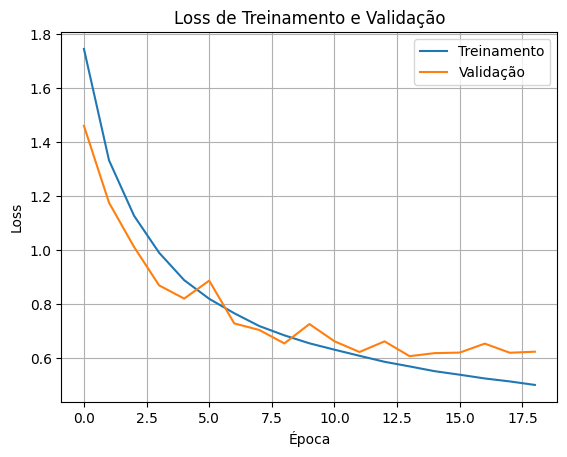

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
net.to(device)

net.load_state_dict(torch.load("best_model_exp1.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
targets, predictions = makePredictions(net, test_loader)

get_scores(targets, predictions)

{'accuracy': 0.8031,
 'balanced_accuracy': np.float64(0.8031),
 'precision': 0.8082089033759585,
 'recall': 0.8031,
 'f1_score': 0.8007381340081614}

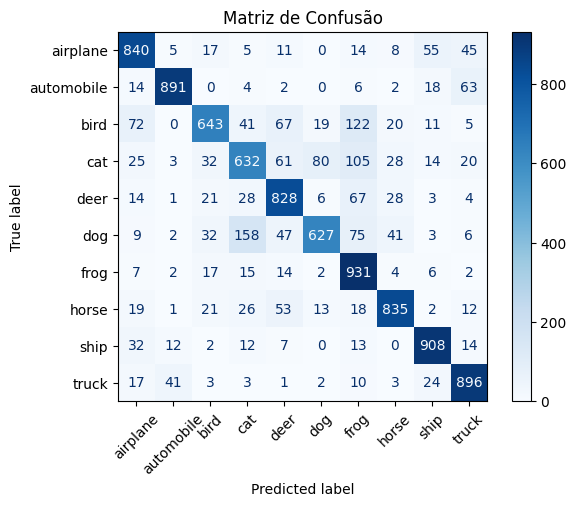

In [ ]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(targets, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()